#ResNet Ablation Study

In [117]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds


#GPU 확인: Colab > Google Compute Engine 백엔드 (GPU)
tf.config.list_physical_devices('GPU')
# print(tf.__version__)
# print(np.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

##Data load : tenserflow dataset > cats_vs_dogs

In [118]:
import urllib3
urllib3.disable_warnings()
tfds.disable_progress_bar()

(ds_train, ds_val, ds_test),ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)
#feature info > num class:2, ['cat', 'dog']
print(ds_info.features)
print(ds_info.features["label"].names)
#num data
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_val))
print(tf.data.experimental.cardinality(ds_test))

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'image/filename': Text(shape=(), dtype=string),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
})
['cat', 'dog']
tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(2326, shape=(), dtype=int64)
tf.Tensor(2326, shape=(), dtype=int64)


##Preprocess

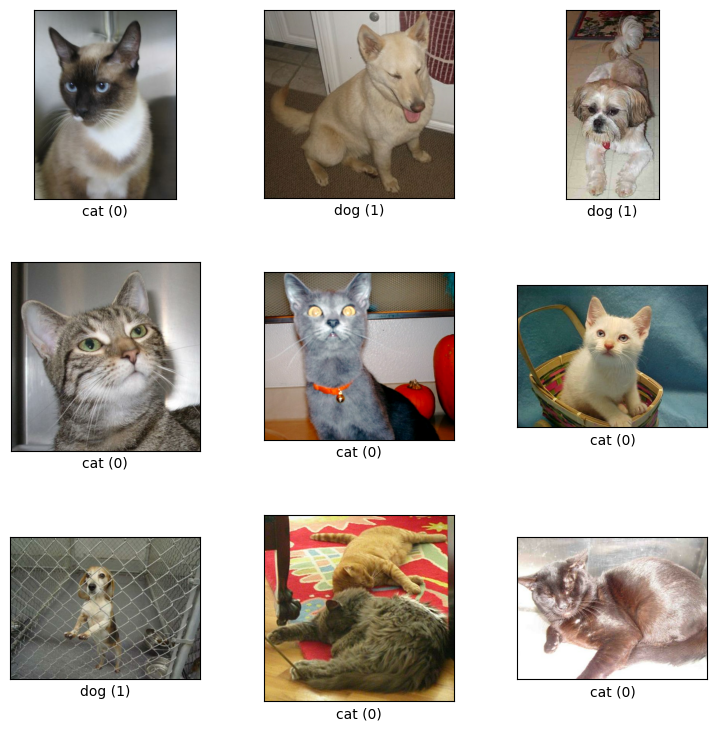

In [119]:
# fig = tfds.show_examples(ds_train, ds_info)
fig = tfds.show_examples(ds_test, ds_info)

In [120]:
IMAGE_SIZE=224
BATCH_SIZE=16
#resize
# def resize_img(image, label):
#     image = tf.cast(image, tf.float32) / 255.
#     image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
#     return image, label

# ds_train = ds_train.map(resize_img)
# ds_val = ds_val.map(resize_img)
# ds_test = ds_test.map(resize_img)

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255)
])


#preprocess layer
data_preprocess = keras.Sequential(
    [
        # #normalize
        # layers.Rescaling(1./255),
        resize_and_rescale,
        #shift
        layers.RandomTranslation(height_factor=(-0.05, 0.05), width_factor=(-0.05, 0.05)),
        #rotate
        layers.RandomRotation(0.05),
        #zoom
        layers.RandomZoom(0.05),
    ]
)

pre_ds_train = ds_train.map(lambda x, y: (data_preprocess(x, training=True), y))
pre_ds_val = ds_val.map(lambda x, y: (data_preprocess(x, training=False), y))
pre_ds_test = ds_test.map(lambda x, y: (data_preprocess(x, training=False), y))

pre_ds_train = pre_ds_train.batch(BATCH_SIZE)
pre_ds_val = pre_ds_val.batch(BATCH_SIZE)
pre_ds_test = pre_ds_test.batch(BATCH_SIZE)

##Model building

In [121]:
from keras import models, layers
from keras import Input
from keras.models import Model, load_model
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add


In [122]:
#resnet50
def conv1_layer(x):
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)

    return x


def conv2_layer(x):
    x = MaxPooling2D((3, 3), 2)(x)

    #skip connection
    shortcut = x
    for i in range(3):
        if (i == 0):
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)


            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            #skip connection
            shortcut = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)

            #Add skip connection
            x = Add()([x, shortcut])
            x = Activation('relu')(x)

            shortcut = x

        else:
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)

            x = Add()([x, shortcut])
            x = Activation('relu')(x)

            shortcut = x

    return x



def conv3_layer(x):
    shortcut = x

    for i in range(4):
        if(i == 0):
            x = Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)

            x = Add()([x, shortcut])
            x = Activation('relu')(x)

            shortcut = x

        else:
            x = Conv2D(128, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)

            x = Add()([x, shortcut])
            x = Activation('relu')(x)

            shortcut = x

    return x



def conv4_layer(x):
    shortcut = x

    for i in range(6):
        if(i == 0):
            x = Conv2D(256, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(1024, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)

            x = Add()([x, shortcut])
            x = Activation('relu')(x)

            shortcut = x

        else:
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)

            x = Add()([x, shortcut])
            x = Activation('relu')(x)

            shortcut = x

    return x


def conv5_layer(x):
    shortcut = x

    for i in range(3):
        if(i == 0):
            x = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(2048, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)

            x = Add()([x, shortcut])
            x = Activation('relu')(x)

            shortcut = x

        else:
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)

            x = Add()([x, shortcut])
            x = Activation('relu')(x)

            shortcut = x

    return x

def create_model():
    # K = 2
    inputs = layers.Input(shape=(224, 224, 3), dtype='float32')
    # x = data_preprocess(inputs)
    x = conv1_layer(inputs)
    x = conv2_layer(x)
    x = conv3_layer(x)
    x = conv4_layer(x)
    x = conv5_layer(x)
    x = GlobalAveragePooling2D()(x)
    outputs = layers.Dense(1, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

resnet50 = create_model()
resnet50.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

resnet50.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_37 (ZeroPadding  (None, 230, 230, 3)  0          ['input_22[0][0]']               
 2D)                                                                                              
                                                                                                  
 conv2d_788 (Conv2D)            (None, 112, 112, 64  9472        ['zero_padding2d_37[0][0]']      
                                )                                                          

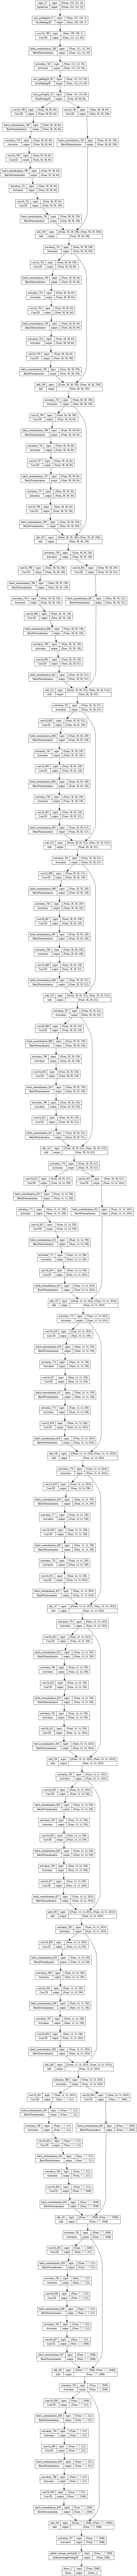

In [123]:
tf.keras.utils.plot_model(resnet50, show_shapes=True, dpi=64)

In [124]:
#plain50
def conv1_layer(x):
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)

    return x


def conv2_layer(x):
    x = MaxPooling2D((3, 3), 2)(x)

    for i in range(3):

        x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    return x

def conv3_layer(x):

    for i in range(3):

        x = Conv2D(128, (1, 1), strides=(1, 1), padding='valid')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    return x

def conv4_layer(x):

    for i in range(3):

        x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    return x

def conv5_layer(x):

    for i in range(3):

        x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    return x

def create_model2():
    # K = 2
    inputs = layers.Input(shape=(224, 224, 3), dtype='float32')
    # x = data_preprocess(inputs)
    x = conv1_layer(inputs)
    x = conv2_layer(x)
    x = conv3_layer(x)
    x = conv4_layer(x)
    x = conv5_layer(x)
    x = GlobalAveragePooling2D()(x)
    outputs = layers.Dense(1, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

plain50 = create_model2()
plain50.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

plain50.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 zero_padding2d_39 (ZeroPadd  (None, 230, 230, 3)      0         
 ing2D)                                                          
                                                                 
 conv2d_841 (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_841 (Ba  (None, 112, 112, 64)     256       
 tchNormalization)                                               
                                                                 
 activation_798 (Activation)  (None, 112, 112, 64)     0         
                                                                 
 zero_padding2d_40 (ZeroPadd  (None, 114, 114, 64)     0  

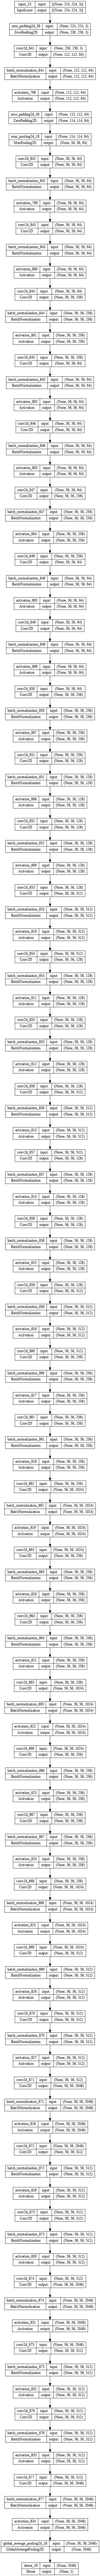

In [125]:
tf.keras.utils.plot_model(plain50, show_shapes=True, dpi=64)

##Train model

In [ ]:
epochs=5
history = plain50.fit(
  pre_ds_train,
  validation_data=pre_ds_val,
  epochs=epochs
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


 452/1164 [==========>...................] - ETA: 16:49 - loss: 0.0000e+00 - accuracy: 0.4949